### importing icevision for dataset loading and model training and other libraries for coco creation

In [ ]:
from icevision.all import *
import numpy as np

import json
import os
from PIL import Image
from pycococreatortools import pycococreatortools

In [2]:
model_type = models.torchvision.mask_rcnn
backbone = model_type.backbones.resnet34_fpn()

In [3]:
mount_path = "/root/data/cv1_transfer/"
ml_data_path = os.path.join(mount_path, "labeled_data")

In [4]:
path = Path(ml_data_path)
codes = np.loadtxt(path/'codes.txt', dtype=str)

In [5]:
def get_chps(path): 
    oil_chps = np.loadtxt(path/'oil_chps.txt', dtype=str)
    density = 0
    num_oilless = density * len(oil_chps)
    oilless_chps = [chp for chp in get_image_files(path/'chp') if chp.stem not in oil_chps]
    mixed_chps = random.sample(oilless_chps,num_oilless) + [path/'chp'/(chp+'.png') for chp in oil_chps]
    return mixed_chps

def get_lbls(fn): return fn.parent.parent/"lbl_no3"/f"{fn.name}"
def splitter_func(path, fn): 
    valid_names = np.loadtxt(path/'valid_names.txt', dtype=str)
    return fn.name.rsplit('_',1)[0] in valid_names # XXX Check to make sure this should be returning True for Valid

drive_files = get_chps(path)

In [6]:
lbl_chps = [get_lbls(x) for x in get_chps(path)]

In [7]:
lcl = Path("../out_data")
path.mkdir(exist_ok=True)
modelpath = lcl

In [8]:
img_dir=f"{path}/chp"

### Making a COCO Dataset for Mask-RCNN, converting single band (assumed single instance) annotations from raster labels

In [9]:
chps = get_chps(path)

In [10]:
info = {
    "description": "CeruleanDataset V1, Binary Slick/Not Slick",
    "url": "none",
    "version": "1.0",
    "year": 2021,
    "contributor": "Skytruth",
    "date_created": "2021/11/12"
}

licenses = [
    {
        "url": "none",
        "id": 1,
        "name": "CeruleanDataset V1, Binary Slick/Not Slick"
    }
]
categories = [{"supercategory":"slick", "id":1,"name":"oil_slick"}]

coco_output = {
    "info": info,
    "licenses": licenses,
    "images": [],
    "annotations": [],
    "categories": categories
}

image_id = 1
segmentation_id = 1

images_d = []

# filter for jpeg images
for i,n in enumerate(chps):
    images_d.append({"file_name": str(n), "height": 512, "width": 512, "id":i})

    # go through each label image to extract annotation
    image = Image.open(str(n))
    image_info = pycococreatortools.create_image_info(
        image_id, os.path.basename(str(n)), image.size)
    coco_output["images"].append(image_info)

    annotation_filename = str(lbl_chps[i])
    arr = np.array(Image.open(annotation_filename))
    if 1 in arr:
        class_id = 1
        category_info = {"id":class_id,"is_crowd":True} # forces compressed RLE format
    else:
        class_id = 0
        category_info = {"id":class_id,"is_crowd":False}
    binary_mask = np.asarray(Image.open(annotation_filename)).astype(np.uint8)

    annotation_info = pycococreatortools.create_annotation_info(
        segmentation_id, image_id, category_info, binary_mask,
        image.size, tolerance=0)

    if annotation_info is not None:
        coco_output["annotations"].append(annotation_info)

    segmentation_id = segmentation_id + 1

    image_id = image_id + 1

with open('{}/instances_slick_train.json'.format(path), 'w') as output_json_file:
    json.dump(coco_output, output_json_file)


In [11]:
class_map = ClassMap(["oil_slick"])
class_map # https://airctic.github.io/icedata/dataset_voc_nb/#define-class_map

<ClassMap: {'background': 0, 'oil_slick': 1}>

In [12]:
parser = parsers.COCOMaskParser(f'{path}/instances_slick_train.json', img_dir)

### Parsing works! we're just trying to test if this trains and evaluates correctly, it's ok if many of these instances don't look like instances for now since the dataset was made for semantic segmentation

It's possible icevision is filtering out all negative samples here during autofixing, which we can check. Our most useful samples will include non-background class hard negatives and positives anyway

  0%|          | 0/434 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


  0%|          | 0/434 [00:00<?, ?it/s]

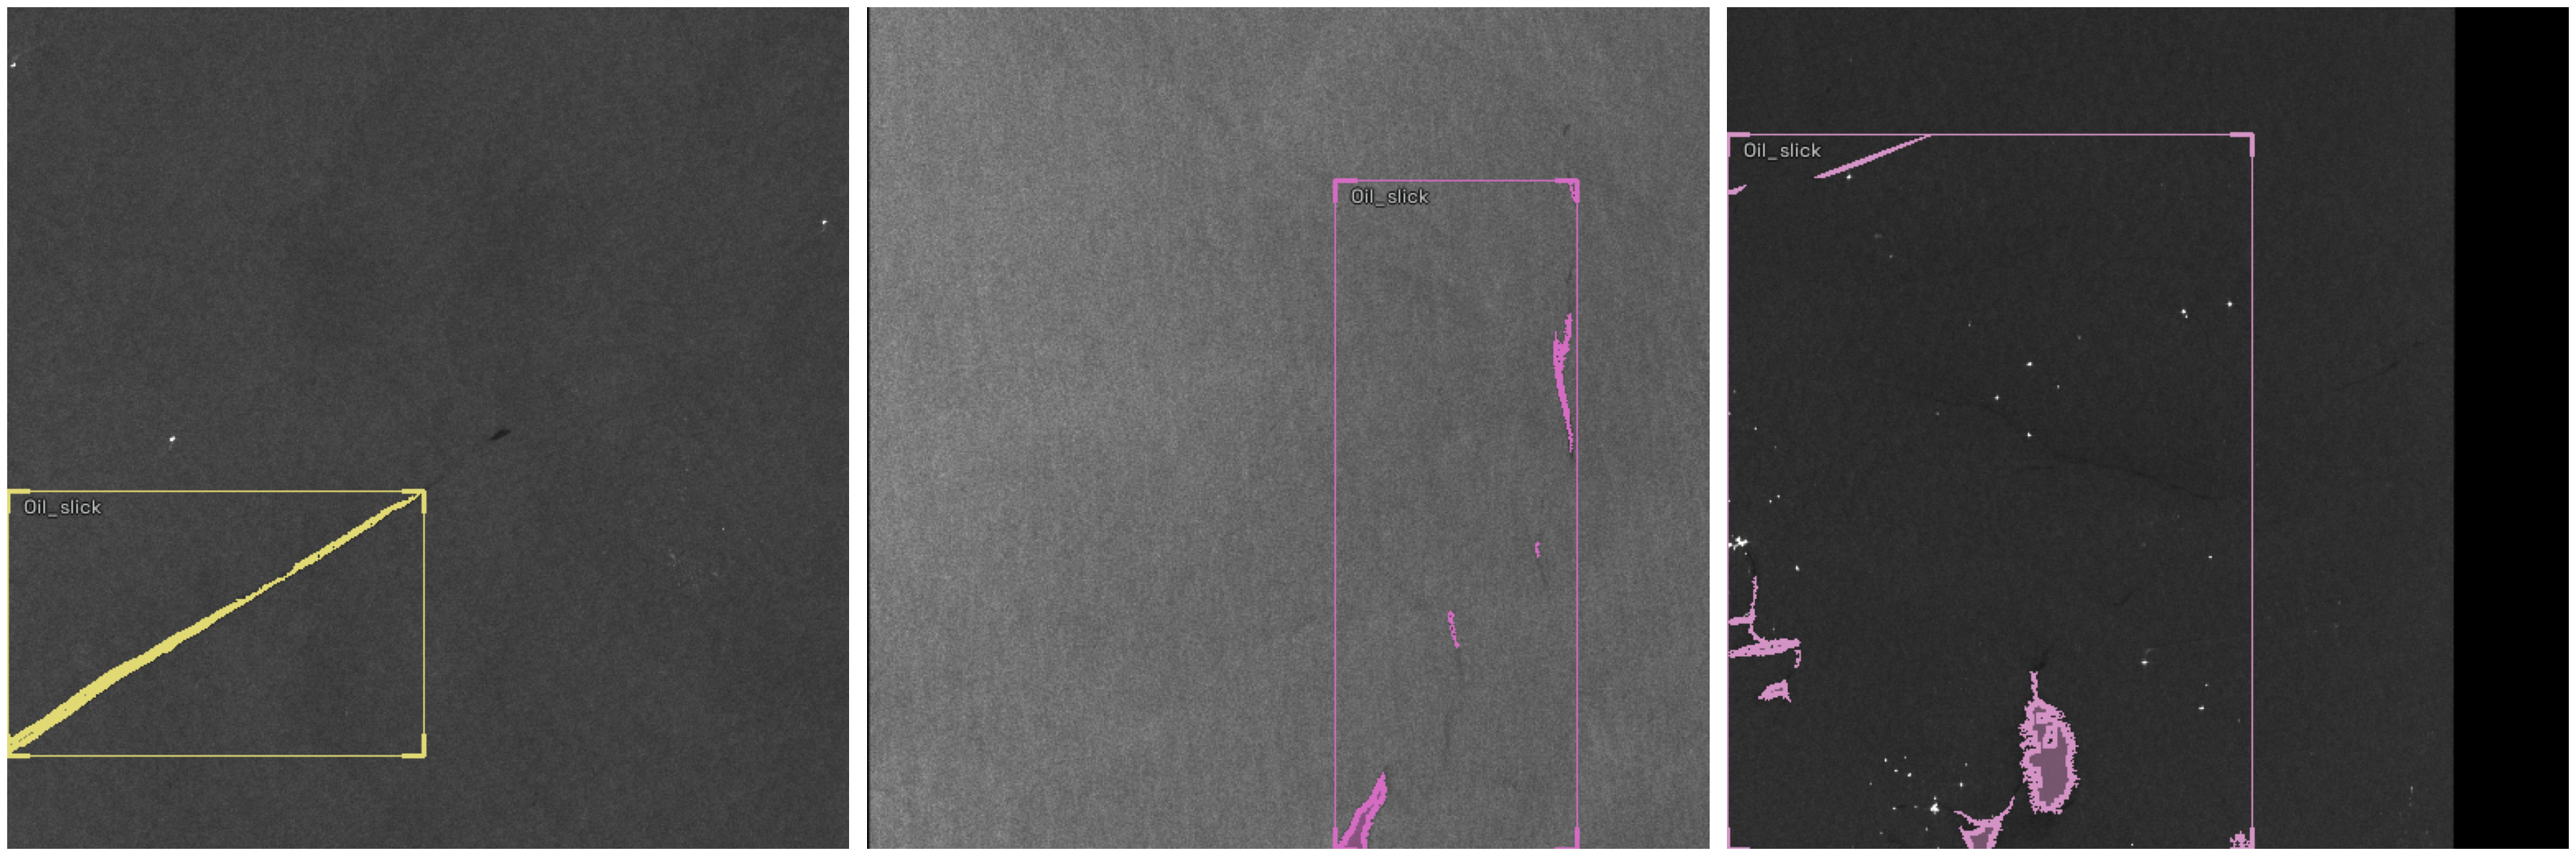

In [23]:
# Parse the annotations to create the train and validation records
train_records, valid_records = parser.parse()
x=show_records(train_records[:3], ncols=3, class_map=class_map)
plt.savefig("train_slick_examples.png")

Normalizing is best practice and necessary for icevision to propoerly display predicition results

In [27]:
train_tfms = tfms.A.Adapter(
    [
        tfms.A.Normalize(),
    ]
)

In [28]:
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=512), tfms.A.Normalize()])

sourced from: https://airctic.com/0.8.1/getting_started_instance_segmentation/

In [ ]:
train_ds.records.autofix??

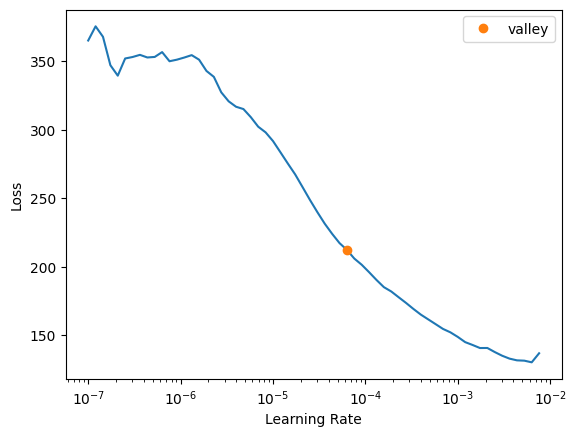

In [37]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

train_dl = model_type.train_dl(train_ds, batch_size=8, num_workers=6, shuffle=True) # adjust num_workers for your processor count
valid_dl = model_type.valid_dl(valid_ds, batch_size=8, num_workers=6, shuffle=False)

model = model_type.model(backbone=backbone(pretrained=False), num_classes=len(parser.class_map))

metrics = [COCOMetric(metric_type=COCOMetricType.mask, print_summary=False)]

learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

lr = learn.lr_find()

In [30]:
lr

SuggestedLRs(valley=2.511886486900039e-05)

The suggested learning rate makes getting to higher confidence predictions take too long. We picked the learning rate arbitrarily below to speed up getting to losses closer to .5 instead of greater than 1. 

In [38]:
learn.fine_tune(30,2.511886486900039e-03)

epoch,train_loss,valid_loss,COCOMetric,time
0,73.817482,42.938095,-1.000000,00:12


epoch,train_loss,valid_loss,COCOMetric,time
0,3.330552,0.614166,-1.000000,00:25
1,1.388426,0.514869,-1.000000,00:27
2,0.872623,0.473119,-1.000000,00:25
3,0.677723,0.475380,-1.000000,00:28
4,0.607698,0.498973,-1.000000,00:25
5,0.576462,0.482767,-1.000000,00:23
6,0.534461,0.448011,-1.000000,00:29
7,0.529534,0.486966,-1.000000,00:31
8,0.523107,0.522987,-1.000000,00:28
9,0.507983,0.410191,-1.000000,00:26


a TODO is to debug the COCOMetric, it should not be -1 given that we are now acheiving detections that intersect with groundtruth.

In [46]:
print(f"approximate time to train 30 epochs in minutes: {25*30/60}")


approximate time to train 30 epochs in minutes: 12.5


The predictions above .7 confidence that roughly line up with groundtruth demonstrates that icevision-trained models can produce predictions that look like they are headed in the correct direction, even for an imperfect training set.

In [ ]:
model_type.show_results??

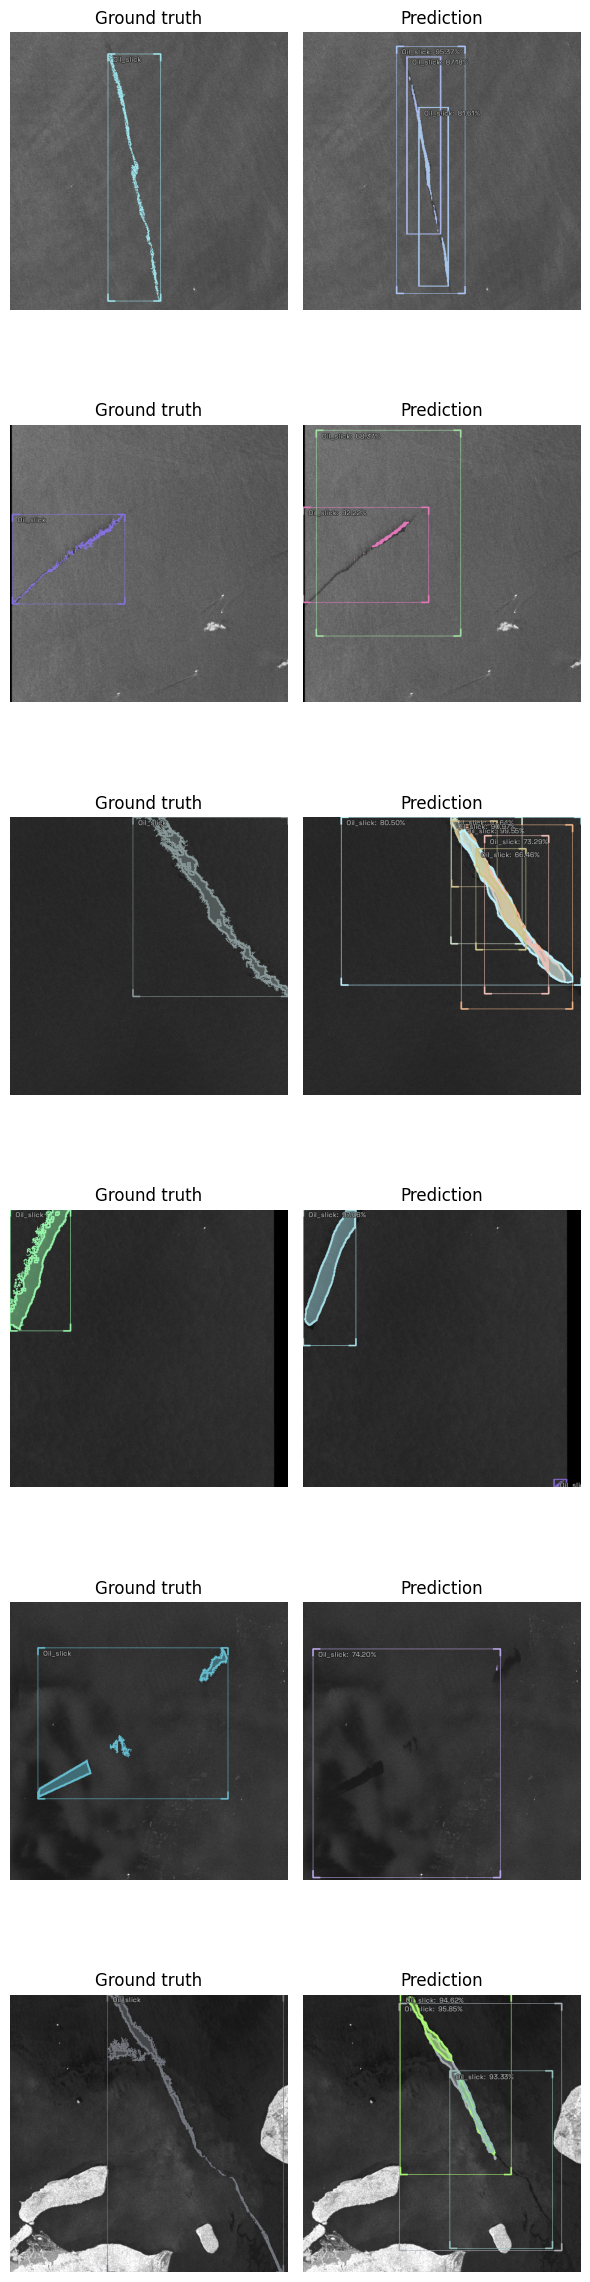

<Figure size 640x480 with 0 Axes>

In [58]:
x = model_type.show_results(model, valid_ds, detection_threshold=.6)
plt.savefig("inference_results.png")

In [ ]:
show_results??